# **Recurrent Neural Networks (d2l.ai)**

In [64]:
%matplotlib inline
import inspect
import collections
import random
import re
import os
import math
import copy
import time
from os.path import exists
import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.functional import log_softmax, pad
from torch.optim.lr_scheduler import LambdaLR
from d2l import torch as d2l



## **9.1 Working with Sequences**



In [2]:
device = None
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [24]:
class Data(d2l.DataModule):
    def __init__(self, batch_size=16, T=1000, num_train=600, tau=4, device=torch.device("cpu")):
        self.save_hyperparameters()
        self.time = torch.arange(1, T+1,dtype=torch.float32, device=device)
        self.x = torch.sin(0.01 * self.time) + torch.randn(T, device=device) * 0.2


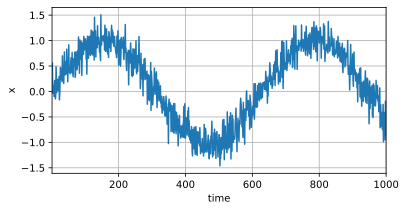

In [26]:
data = Data(device=device)
d2l.plot(data.time.cpu(), data.x.cpu(), "time", "x", xlim=[1,1000], figsize=(6,3))

To begin with, we try a model that acts as though the data satisfies a $\tau$ order Markov condition, and thus predicts $x_t$ using only the past $\tau$ observations. Thus, for each timestep, we have an example with label $y = x_t$ and features $\mathbf{x}_t = [x_{t-\tau}, \ldots, x_{t-1}]$.

In [29]:
@d2l.add_to_class(Data)
def get_dataloader(self, train):
    features = [self.x[i : self.T  - self.tau + i] for i in range(self.tau)]
    self.features = torch.stack(features, 1)
    self.labels = self.x[self.tau:].reshape((-1,1))
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader([self.features, self.labels], train, i)

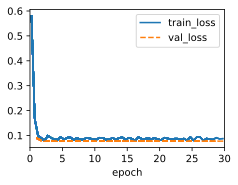

In [55]:

model = d2l.LinearRegression(lr=0.01).to(device)
trainer = d2l.Trainer(max_epochs=30)
trainer.fit(model, data)

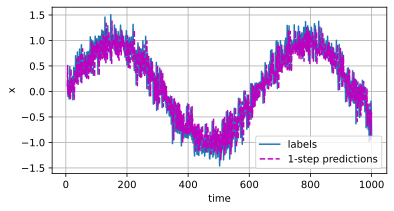

In [60]:
one_step_pred = model(data.features).detach()
one_step_pred = one_step_pred.to(torch.device("cpu"))
one_step_pred = one_step_pred.numpy()
d2l.plot(data.time[data.tau:].cpu(), [data.labels.cpu(), one_step_pred], "time", "x",
         legend=["labels", "1-step predictions"], figsize=(6,3))

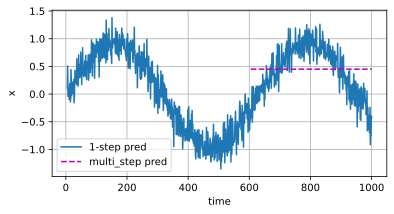

In [62]:
multi_step_pred = torch.zeros(data.T, device=device)
multi_step_pred[:] = data.x.to(device)
for i in range(data.num_train + data.tau, data.T):
    multi_step_pred[i] = model(
        multi_step_pred[i - data.tau:i].reshape((1, -1)))
multi_step_pred = multi_step_pred.detach().cpu().numpy()

d2l.plot([(data.time[data.tau:]).cpu(), (data.time[data.num_train+data.tau:]).cpu()],
         [one_step_pred, multi_step_pred[data.num_train+data.tau:]], 'time',
         'x', legend=['1-step pred', 'multi_step pred'], figsize=(6, 3))

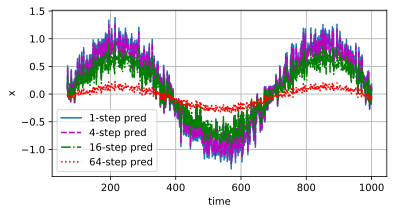

In [63]:
def k_step_pred(k):
    features = []
    for i in range(data.tau):
        features.append(data.x[i : i+data.T-data.tau-k+1])
    # The (i+tau)-th element stores the (i+1)-step-ahead predictions
    for i in range(k):
        pred = model(torch.stack(features[i : i+data.tau], 1))
        features.append(pred.reshape(-1))
    return features[data.tau:]

steps = (1, 4, 16, 64)
pred = k_step_pred(steps[-1])
d2l.plot((data.time[data.tau+steps[-1]-1:]).cpu(),
         [pred[k - 1].cpu().detach().numpy() for k in steps], 'time', 'x',
         legend=[f'{k}-step pred' for k in steps], figsize=(6, 3))


## **9.2 Converting Raw Text to Sequence Data**

Our typical preprocessing pipeline for sequence data modelled as a sequence of words is:

1. Load text as strings into memory.
2. Split the string into tokens.
3. Build a vocabulary dictionary to associate each vocabulary element with a numerical index.
4. Convert the text into sequences of numerical indices.

Here we will work with H G Wells' "The Time Machine", a book with about 30,000 words.

In [65]:
class TimeMachine(d2l.DataModule):
    def _download(self):
        """Download and return as a string."""
        fname = d2l.download(d2l.DATA_URL + 'timemachine.txt', self.root,
                             '090b5e7e70c295757f55df93cb0a180b9691891a')
        with open(fname) as f:
            return f.read()

In [66]:
data = TimeMachine()
raw_text = data._download()
raw_text[:50]

'The Time Machine, by H. G. Wells [1898]\n\n\n\n\nI\n\n\nTh'

In [74]:
@d2l.add_to_class(TimeMachine)
def _preprocess(self, text):
    return re.sub('[^A-Za-z]+', ' ', text).lower()
text = data._preprocess(raw_text)

In [75]:
text[:100]

'the time machine by h g wells i the time traveller for so it will be convenient to speak of him was '

Tokens are the indivisible units of a text, but what constitutes a token is a design choice.

In [77]:
@d2l.add_to_class(TimeMachine)
def _tokenize(self, text):
    return text.split(sep=" ")

@d2l.add_to_class(TimeMachine)
def _tokenize_char(self, text):
    return list(text)

In [79]:
character_tokens = data._tokenize_char(text)
tokens = data._tokenize(text)

These tokens are still strings, but the inputs to our models must be numerical. So we will construct vocabularies that associate a distinct index value to each distinct token. For this, we will need to identify the set of unique tokens in our training corpus. Rare vocabulary elements are often dropped for convenience. Whenever we encounter a token at test time that has not previously been seen, we represent it by the special `"<unk>"` token, signifying an *unknown* value.

In [81]:
class Vocab:
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)
        
        self.idx_to_token = list(sorted(set(["<unk>"] + reserved_tokens + [
            token for token, freq in self.token_freqs if freq >= min_freq
        ])))
        self.token_to_idx = {token:idx for idx,token in enumerate(self.idx_to_token)}
        
    def __len__(self):
        return len(self.idx_to_token)
    
    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk) #if unavailable, self.unk
        return [self.__getitem__(token) for token in tokens]
    
    def to_tokens(self, indices):
        if hasattr(indices, "__len__") and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]
    
    @property
    def unk(self):
        return self.token_to_idx["<unk>"]
    
    

In [82]:
vocab = Vocab(tokens, min_freq=5)
char_vocab = Vocab(character_tokens)

In [83]:
indices = vocab[tokens[:10]]
print('indices:', indices)
print('words:', vocab.to_tokens(indices))

indices: [698, 724, 413, 91, 0, 0, 789, 337, 698, 724]
words: ['the', 'time', 'machine', 'by', '<unk>', '<unk>', 'wells', 'i', 'the', 'time']


In [84]:
char_indices = char_vocab[character_tokens[:10]]
print('indices:', char_indices)
print('words:', char_vocab.to_tokens(char_indices))

indices: [21, 9, 6, 0, 21, 10, 14, 6, 0, 14]
words: ['t', 'h', 'e', ' ', 't', 'i', 'm', 'e', ' ', 'm']


In [91]:
@d2l.add_to_class(TimeMachine)
def build(self, raw_text, vocab=None, by_character=True):
    if by_character:
        tokens = self._tokenize_char(self._preprocess(raw_text))
        if vocab is None: vocab = Vocab(tokens)
        corpus = [vocab[token] for token in tokens]
        return corpus, vocab
    else:
        tokens = self._tokenize(self._preprocess(raw_text))
        if vocab is None: vocab = Vocab(tokens)
        corpus = [vocab[token] for token in tokens]
        return corpus, vocab

In [92]:
char_corpus, char_vocab = data.build(raw_text, by_character=True)


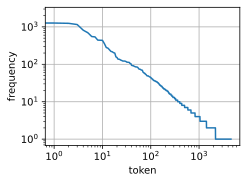

In [97]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel="token", ylabel="frequency", xscale="log", yscale="log")

In [98]:
words = text.split()

In [102]:
bigram_tokens = ["--".join(pair) for pair in zip(words[:-1], words[1:])]
bigram_vocab = Vocab(bigram_tokens)
bigram_vocab.token_freqs[100:120]

[('my--own', 18),
 ('up--the', 18),
 ('the--hill', 18),
 ('of--them', 18),
 ('i--began', 18),
 ('among--the', 18),
 ('there--is', 17),
 ('of--his', 17),
 ('i--went', 17),
 ('at--my', 17),
 ('don--t', 16),
 ('and--that', 16),
 ('the--earth', 16),
 ('it--s', 16),
 ('was--in', 16),
 ('saw--the', 16),
 ('here--and', 16),
 ('i--looked', 16),
 ('the--first', 16),
 ('came--to', 16)]

In [104]:
trigram_tokens = ['--'.join(triple) for triple in zip(
    words[:-2], words[1:-1], words[2:])]
trigram_vocab = d2l.Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[('the--time--traveller', 59),
 ('the--time--machine', 30),
 ('the--medical--man', 24),
 ('it--seemed--to', 16),
 ('it--was--a', 15),
 ('here--and--there', 15),
 ('seemed--to--me', 14),
 ('i--did--not', 14),
 ('i--saw--the', 13),
 ('i--began--to', 13)]

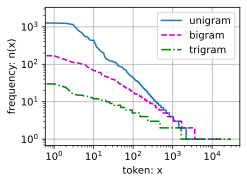

In [105]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
         ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram'])

## **Chapter 9.3 Language Models**

The goal of language models is to estimate the joint probability of the whole sequence $P(x_1,\ldots, x_T)$. 

We might attempt to estimate the conditional probability of two words occurring one after the other by considering the ratio of the number of occurrences of the joint pair to the number of occurrences of just the first word, but word pairs occur very infrequently. It may be tricky to find enough occurrences to get accurate estimates. A common solution is to apply some form of *Laplace smoothing* where a small constant is added to all counts. But models like this get unwieldy rather quickly. So we rely on neural networks for language modelling instead.

We estimate the quality of the language model by considering the expected "surprise" or *perplexity* on observing the input sentence given the current model. A very good model will not be very surprised (low cross-entropy) when seeing the true sentence.

In [ ]:
@d2l.add_to_class(d2l.TimeMachine)
def __init__(self, batch_size, num_steps, num_train=10000, num_val=5000, 
             by_char=True, device=torch.device("cpu")):
    super(TimeMachine, self).__init__()
    self.save_hyperparameters()
    corpus, self.vocab = self.build(self._download(), by_character=True)
    array = torch.tensor([corpus[i:i+num_steps+1] for i in range(0,len(corpus)- num_steps-1)]).to(device)
    self.X, self.Y = array[:,:-1], array[:, 1:]

# **Attention**



An attention layer explicitly selects related information. The memory consists of key-value pairs, and the output will be close to the values whose keys are similar to the query.

We assume that the query is $q \in \mathbb{R}^{d_q}$ and the memory is $(k_1,v_1), \ldots, (k_n,v_n) \in \mathbb{R}^{d_k} \times \mathbb{R}^{d_v}$. Then we compute the scores $s(q, k_i)$, and then attention as the softmax of these scores. 

In a dot product attention layer $d_k = d_q$ and $$\alpha(q,k) = \frac{q \cdot k}{\sqrt{d}}$$ The vectorized version. If we have $m$ queries $Q \in \mathbb{R}^{m \times d}$ and $K \in \mathbb{R}^{n \times d}$ then the score function is $\alpha(Q,K) = \frac{QK^T}{\sqrt{d}}$.


If we have a multilayer perception attention, we have $\alpha(k,q) = v^T \tanh(W_k k + W_q q)$ where $W_k \in \mathbb{R}^{h \times d_k}$ and $W_q  \in \mathbb{R}^{h \times d_q}$